In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
board = "black"

In [4]:
cam_filename = "../bad_cams_"+board+".csv"
data_cams = np.loadtxt(cam_filename, delimiter=",", dtype=int)
good_filename = "../good_"+board+".csv"
data_good = np.loadtxt(good_filename, delimiter=",", dtype=int)

FileNotFoundError: ../bad_cams_black.csv not found.

px_filename = "../bad_pxs_"+board+".csv"
data_pxs = np.loadtxt(px_filename, delimiter=",", dtype=int)
plt.figure(figsize=(16, 8))
bad_px = [[_ in data_pxs[data_pxs[:, 0] == core, 3] for _ in range(2048)] for core in range(4)]
plt.imshow(np.concatenate([np.reshape(_, (64, 32)) for _ in bad_px], axis=1))

while True:
    bad_px_filled = [[False] * 2048 for _ in range(4)]
    for core, bad_px_core in enumerate(bad_px):
        for i in range(2048):
            for j in range(3, 11):
                flag_j = bad_px_core[i] + bad_px_core[i ^ (1 << j)]
                if core == 2 and i == 0:
                    print(bad_px_core[i], bad_px_core[i ^ (1 << j)], flag_j)
                for k in range(2, j):
                    flag_k = flag_j + bad_px_core[i ^ (1 << k)] + bad_px_core[i ^ (1 << j) ^ (1 << k)]
                    for l in range(1, k):
                        flag_l = flag_k + bad_px_core[i ^ (1 << l)] + bad_px_core[i ^ (1 << j) ^ (1 << l)] + \
                            bad_px_core[i ^ (1 << k) ^ (1 << l)] + bad_px_core[i ^ (1 << j) ^ (1 << k) ^ (1 << l)]
                        for m in range(l):
                            flag = flag_l + bad_px_core[i ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << j) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << k) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << j) ^ (1 << k) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << l) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << j) ^ (1 << l) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << k) ^ (1 << l) ^ (1 << m)] + \
                                bad_px_core[i ^ (1 << j) ^ (1 << k) ^ (1 << l) ^ (1 << m)]
                            if flag > 14:
                                break
                        if flag > 14:
                            break
                    if flag > 14:
                        break
                if flag > 14:
                    bad_px_filled[core][i] = True
                    break
    if np.sum(bad_px != bad_px_filled):
        bad_px = [[_ for _ in bad_px_core] for core, bad_px_core in enumerate(bad_px_filled)]
    else:
        break

plt.figure(figsize=(16, 8))
plt.imshow(np.concatenate([np.reshape(_, (64, 32)) for _ in bad_px], axis=1))

plt.figure(figsize=(16, 8))
plt.imshow(np.concatenate([np.reshape(_, (64, 32)) for _ in bad_px_filled], axis=1))

tag_candidates = [[[_ for _ in range(1024) if not bad_px_core[_]],
                   [_ for _ in range(1024, 2048) if not bad_px_core[_]]] for bad_px_core in bad_px]

tag_candidates

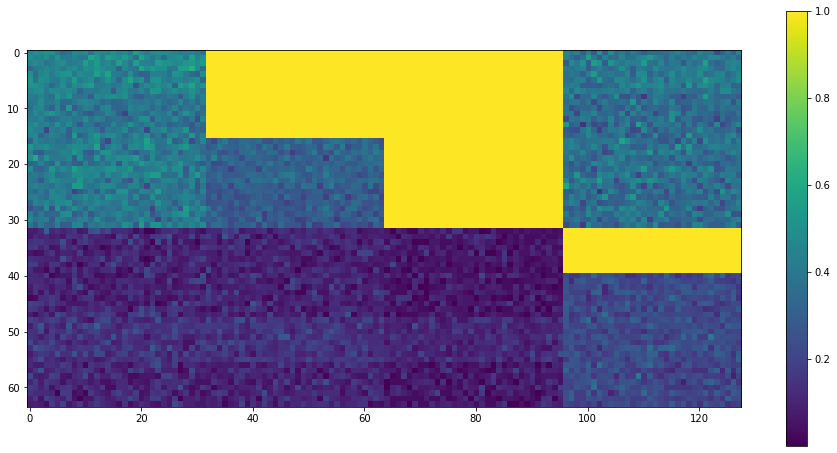

In [4]:
plt.figure(figsize=(16, 8))
tag_bad_count = np.zeros((4, 2048))
tag_good_count = np.zeros((4, 2048))
for core in range(4):
    tag_bad_count[core] = np.bincount(data_cams[data_cams[:,0]==core, 3], minlength=2048)
    tag_good_count[core] = np.bincount(data_good[data_good[:,0]==core, 3], minlength=2048) 
plt.imshow(np.concatenate([np.reshape((tag_bad_count[core] + 0.01) /
                                      (tag_bad_count[core] + tag_good_count[core] + 0.01), (64, 32))
                           for core in range(4)], axis=1))
plt.colorbar()
plt.show()

In [5]:
tag_candidates = [[_ for _ in range(2048) if (tag_bad_count[core] + tag_good_count[core])[_] > 0] for core in range(4)]

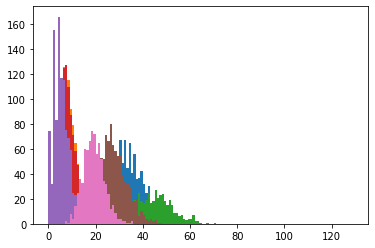

In [6]:
for core in range(4):
    data_cams_tag = np.array(data_cams[data_cams[:, 0] == core, 3])
    data_cams_tag_0_1024 = data_cams_tag[data_cams_tag < 1024]
    data_cams_tag_1024_2048 = data_cams_tag[data_cams_tag >= 1024]
    if tag_candidates[core]:
        if tag_candidates[core][0] < 1024:
            plt.hist((np.bincount(data_cams_tag_0_1024.astype("int"), minlength=2048)
                      [[_ for _ in tag_candidates[core] if _ < 1024]].tolist()), range(130))
        if tag_candidates[core][-1] >= 1024:
            plt.hist((np.bincount(data_cams_tag_1024_2048.astype("int"), minlength=2048)
                      [[_ for _ in tag_candidates[core] if _ >= 1024]].tolist()), range(130))

core 0 tags 0-1023 failing probability 0.12642288208007812
core 0 tags 1024-2047 failing probability 0.030010223388671875
core 1 tags 0-1023 failing probability 0.16619110107421875
core 1 tags 1024-2047 failing probability 0.02819061279296875
core 2 tags 1024-2047 failing probability 0.0192718505859375
core 3 tags 0-1023 failing probability 0.10205459594726562
core 3 tags 1024-2047 failing probability 0.073333740234375


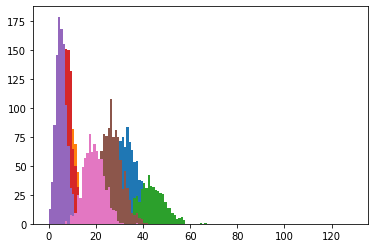

In [7]:
p = np.zeros((2, 4))
for core in range(4):
    data_cams_tag = np.array(data_cams[data_cams[:, 0] == core, 3])
    data_cams_tag_0_1024 = data_cams_tag[data_cams_tag < 1024]
    data_cams_tag_1024_2048 = data_cams_tag[data_cams_tag >= 1024]
    tags_0_1024 = sum([_ < 1024 for _ in tag_candidates[core]])
    tags_1024_2048 = sum([_ >= 1024 for _ in tag_candidates[core]])
    n = 256
    if tags_0_1024:
        p[0][core] = len(data_cams_tag_0_1024)/tags_0_1024/n
        print(f"core {core} tags 0-1023 failing probability {p[0][core]}")
        plt.hist(np.random.binomial(n, p[0][core], tags_0_1024), range(130))
    if tags_1024_2048:
        p[1][core] = len(data_cams_tag_1024_2048)/tags_1024_2048/n
        print(f"core {core} tags 1024-2047 failing probability {p[1][core]}")
        plt.hist(np.random.binomial(n, p[1][core], tags_1024_2048), range(130))

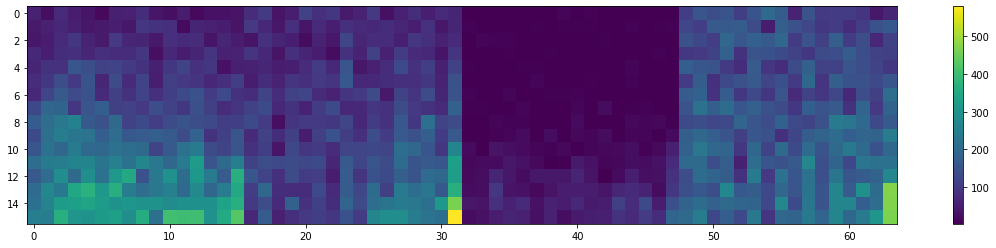

In [8]:
plt.figure(figsize=(20, 4))
tag_bad_count = np.zeros((4, 256))
tag_good_count = np.zeros((4, 256))
for core in range(4):
    tag_bad_count[core] = np.bincount(data_cams[data_cams[:,0]==core, 1], minlength=256)
    tag_good_count[core] = np.bincount(data_good[data_good[:,0]==core, 1], minlength=256) 
plt.imshow(np.concatenate([np.reshape(tag_bad_count[core], (16, 16))
                           for core in range(4)], axis=1))
plt.colorbar()
plt.show()

In [9]:
cams_matrix_0_1024 = np.zeros((4, 256, 64))
success_matrix_0_1024 = np.zeros((4, 256, 64))
cams_matrix_1024_2048 = np.zeros((4, 256, 64))
success_matrix_1024_2048 = np.zeros((4, 256, 64))
for core_neuron_synapse_tag in data_cams:
    if core_neuron_synapse_tag[3] < 1024:
        cams_matrix_0_1024[core_neuron_synapse_tag[0], core_neuron_synapse_tag[1], core_neuron_synapse_tag[2]] += 1
    else:
        cams_matrix_1024_2048[core_neuron_synapse_tag[0], core_neuron_synapse_tag[1], core_neuron_synapse_tag[2]] += 1
for core_neuron_synapse_tag in data_good:
    if core_neuron_synapse_tag[3] < 1024:
        success_matrix_0_1024[core_neuron_synapse_tag[0], core_neuron_synapse_tag[1], core_neuron_synapse_tag[2]] += 1
    else:
        success_matrix_1024_2048[core_neuron_synapse_tag[0], core_neuron_synapse_tag[1], core_neuron_synapse_tag[2]] += 1

data_good[np.logical_and(np.logical_and(data_good[:,0] == 0, data_good[:,1] == 10), data_good[:,2] == 56), :]

len(np.nonzero(cams_matrix_1024_2048 + success_matrix_1024_2048 == 0))

tag_candidates[core]

In [10]:
for core in range(4):
    if tag_candidates[core] and tag_candidates[core][0] < 1024:
            cams_matrix_0_1024[core] /= (cams_matrix_0_1024[core] + success_matrix_0_1024[core])
    else:
        cams_matrix_0_1024[core] = 1
    if tag_candidates[core] and tag_candidates[core][-1] >= 1024:
        cams_matrix_1024_2048[core] /= (cams_matrix_1024_2048[core] + success_matrix_1024_2048[core])
    else:
        cams_matrix_1024_2048[core] = 1

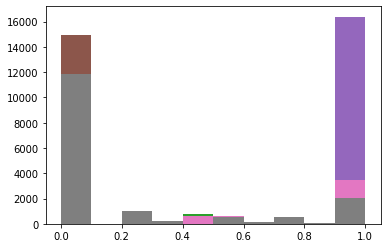

In [11]:
for core in range(4):
    plt.hist(cams_matrix_0_1024[core].flatten(), np.arange(0, 1.1, 0.1))
    plt.hist(cams_matrix_1024_2048[core].flatten(), np.arange(0, 1.1, 0.1))

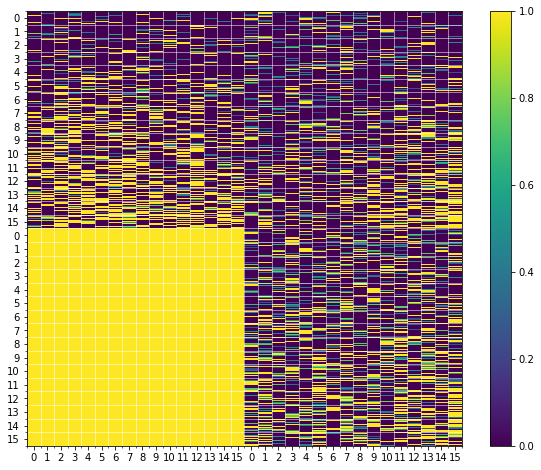

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(np.concatenate([np.concatenate([np.transpose(np.reshape(np.transpose(np.reshape(
    cams_matrix_0_1024[core_row + core_col * 2], (16, 16, 64)), (1, 0, 2)), (16, 16*64)))
                                           for core_col in range(2)], axis=0)
                           for core_row in range(2)], axis=1),
           aspect=1/64,interpolation='none')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 32))
ax.set_yticks(np.arange(32, 2048, 64))

# Labels for major ticks
ax.set_xticklabels(list(range(16))*2)
ax.set_yticklabels(list(range(16))*2)

# Minor ticks
ax.set_xticks(np.arange(-.5, 32, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2048, 64), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)

plt.colorbar()
plt.show()

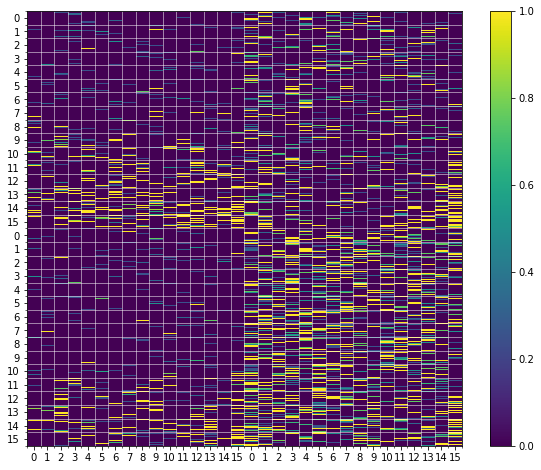

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(np.concatenate([np.concatenate([np.transpose(np.reshape(np.transpose(np.reshape(
    cams_matrix_1024_2048[core_row + core_col * 2], (16, 16, 64)), (1, 0, 2)), (16, 16*64)))
                                           for core_col in range(2)], axis=0)
                           for core_row in range(2)], axis=1),
           aspect=1/64,interpolation='none')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 32))
ax.set_yticks(np.arange(32, 2048, 64))

# Labels for major ticks
ax.set_xticklabels(list(range(16))*2)
ax.set_yticklabels(list(range(16))*2)

# Minor ticks
ax.set_xticks(np.arange(-.5, 32, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2048, 64), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)

plt.colorbar()
plt.show()

In [14]:
import json

In [15]:
profile = {}
profile["tags"] = [[[_ for _ in tag_candidates_core if _ < 1024],
                    [_ for _ in tag_candidates_core if _ >= 1024]] for tag_candidates_core in tag_candidates]
profile["prob"] = p.tolist()
profile["cams"] = [[[[cams_matrix_0_1024[core][neuron][synapse],
                      cams_matrix_1024_2048[core][neuron][synapse]]
                     for synapse in range(64)] for neuron in range(256)] for core in range(4)]
with open("cams_profile_" + board + ".json", "w") as f:
    json.dump(profile, f)

p

sum(cams_matrix_0_1024.flatten() < cams_matrix_1024_2048.flatten())